In [ ]:
! pip install d2l==0.17.2
! pip install torchvision
! pip install torch-summary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip '/content/drive/MyDrive/archive.zip'

In [ ]:
!ls
!unzip 'archive.zip'

In [2]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
import argparse
import os
from torchvision import datasets, models, transforms

In [ ]:
!ls './deepfake_database/deepfake_database/train:test'

In [3]:
train_dataset = torchvision.datasets.ImageFolder('./deepfake_database/deepfake_database/train:test', transform=transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)]))
val_dataset = torchvision.datasets.ImageFolder('./deepfake_database/deepfake_database/validation', transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * 3, [0.5] * 3)
    ]))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=False, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True, drop_last=False, num_workers=2)
train_dataset_size = len(train_dataset)
val_dataset_size = len(val_dataset)

In [4]:
import os
import argparse


import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torchvision

class Meso4(nn.Module):
	def __init__(self, num_classes=2):
		super(Meso4, self).__init__()
		self.num_classes = num_classes
		self.conv1 = nn.Conv2d(3, 8, 3, padding=1, bias=False)
		self.bn1 = nn.BatchNorm2d(8)
		self.relu = nn.ReLU(inplace=True)
		self.leakyrelu = nn.LeakyReLU(0.1)

		self.conv2 = nn.Conv2d(8, 8, 5, padding=2, bias=False)
		self.bn2 = nn.BatchNorm2d(16)
		self.conv3 = nn.Conv2d(8, 16, 5, padding=2, bias=False)
		self.conv4 = nn.Conv2d(16, 16, 5, padding=2, bias=False)
		self.maxpooling1 = nn.MaxPool2d(kernel_size=(2, 2))
		self.maxpooling2 = nn.MaxPool2d(kernel_size=(4, 4))
		#flatten: x = x.view(x.size(0), -1)
		self.dropout = nn.Dropout2d(0.5)
		self.fc1 = nn.Linear(16*8*8, 16)
		self.fc2 = nn.Linear(16, num_classes)

	def forward(self, input):
		x = self.conv1(input) #(8, 256, 256)
		x = self.relu(x)
		x = self.bn1(x)
		x = self.maxpooling1(x) #(8, 128, 128)

		x = self.conv2(x) #(8, 128, 128)
		x = self.relu(x)
		x = self.bn1(x)
		x = self.maxpooling1(x) #(8, 64, 64)

		x = self.conv3(x) #(16, 64, 64)
		x = self.relu(x)
		x = self.bn2(x)
		x = self.maxpooling1(x) #(16, 32, 32)

		x = self.conv4(x) #(16, 32, 32)
		x = self.relu(x)
		x = self.bn2(x)
		x = self.maxpooling2(x) #(16, 8, 8)

		x = x.view(x.size(0), -1) #(Batch, 16*8*8)
		x = self.dropout(x)
		x = self.fc1(x) #(Batch, 16)
		x = self.leakyrelu(x)
		x = self.dropout(x)
		x = self.fc2(x)

		return x


class MesoInception4(nn.Module):
	def __init__(self, num_classes=2):
		super(MesoInception4, self).__init__()
		self.num_classes = num_classes
		#InceptionLayer1
		self.Incption1_conv1 = nn.Conv2d(3, 1, 1, padding=0, bias=False)
		self.Incption1_conv2_1 = nn.Conv2d(3, 4, 1, padding=0, bias=False)
		self.Incption1_conv2_2 = nn.Conv2d(4, 4, 3, padding=1, bias=False)
		self.Incption1_conv3_1 = nn.Conv2d(3, 4, 1, padding=0, bias=False)
		self.Incption1_conv3_2 = nn.Conv2d(4, 4, 3, padding=2, dilation=2, bias=False)
		self.Incption1_conv4_1 = nn.Conv2d(3, 2, 1, padding=0, bias=False)
		self.Incption1_conv4_2 = nn.Conv2d(2, 2, 3, padding=3, dilation=3, bias=False)
		self.Incption1_bn = nn.BatchNorm2d(11)


		#InceptionLayer2
		self.Incption2_conv1 = nn.Conv2d(11, 2, 1, padding=0, bias=False)
		self.Incption2_conv2_1 = nn.Conv2d(11, 4, 1, padding=0, bias=False)
		self.Incption2_conv2_2 = nn.Conv2d(4, 4, 3, padding=1, bias=False)
		self.Incption2_conv3_1 = nn.Conv2d(11, 4, 1, padding=0, bias=False)
		self.Incption2_conv3_2 = nn.Conv2d(4, 4, 3, padding=2, dilation=2, bias=False)
		self.Incption2_conv4_1 = nn.Conv2d(11, 2, 1, padding=0, bias=False)
		self.Incption2_conv4_2 = nn.Conv2d(2, 2, 3, padding=3, dilation=3, bias=False)
		self.Incption2_bn = nn.BatchNorm2d(12)

		#Normal Layer
		self.conv1 = nn.Conv2d(12, 16, 5, padding=2, bias=False)
		self.relu = nn.ReLU(inplace=True)
		self.leakyrelu = nn.LeakyReLU(0.1)
		self.bn1 = nn.BatchNorm2d(16)
		self.maxpooling1 = nn.MaxPool2d(kernel_size=(2, 2))

		self.conv2 = nn.Conv2d(16, 16, 5, padding=2, bias=False)
		self.maxpooling2 = nn.MaxPool2d(kernel_size=(4, 4))

		self.dropout = nn.Dropout2d(0.5)
		self.fc1 = nn.Linear(16*8*8, 16)
		self.fc2 = nn.Linear(16, num_classes)


	#InceptionLayer
	def InceptionLayer1(self, input):
		x1 = self.Incption1_conv1(input)
		x2 = self.Incption1_conv2_1(input)
		x2 = self.Incption1_conv2_2(x2)
		x3 = self.Incption1_conv3_1(input)
		x3 = self.Incption1_conv3_2(x3)
		x4 = self.Incption1_conv4_1(input)
		x4 = self.Incption1_conv4_2(x4)
		y = torch.cat((x1, x2, x3, x4), 1)
		y = self.Incption1_bn(y)
		y = self.maxpooling1(y)

		return y

	def InceptionLayer2(self, input):
		x1 = self.Incption2_conv1(input)
		x2 = self.Incption2_conv2_1(input)
		x2 = self.Incption2_conv2_2(x2)
		x3 = self.Incption2_conv3_1(input)
		x3 = self.Incption2_conv3_2(x3)
		x4 = self.Incption2_conv4_1(input)
		x4 = self.Incption2_conv4_2(x4)
		y = torch.cat((x1, x2, x3, x4), 1)
		y = self.Incption2_bn(y)
		y = self.maxpooling1(y)

		return y

	def forward(self, input):
		x = self.InceptionLayer1(input) #(Batch, 11, 128, 128)
		x = self.InceptionLayer2(x) #(Batch, 12, 64, 64)

		x = self.conv1(x) #(Batch, 16, 64 ,64)
		x = self.relu(x)
		x = self.bn1(x)
		x = self.maxpooling1(x) #(Batch, 16, 32, 32)

		x = self.conv2(x) #(Batch, 16, 32, 32)
		x = self.relu(x)
		x = self.bn1(x)
		x = self.maxpooling2(x) #(Batch, 16, 8, 8)

		x = x.view(x.size(0), -1) #(Batch, 16*8*8)
		x = self.dropout(x)
		x = self.fc1(x) #(Batch, 16)
		x = self.leakyrelu(x)
		x = self.dropout(x)
		x = self.fc2(x)

		return x



In [19]:
model = MesoInception4()
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
model = nn.DataParallel(model)
save_loss = {'train':[], 'test':[]}
save_acc = {'train':[], 'test':[]}
print(type(save_loss))
print(save_loss.keys())

<class 'dict'>
dict_keys(['train', 'test'])


In [16]:
best_model_wts = model.state_dict()
best_acc = 0.0
iteration = 0
batch_size = 64
model_name = 'madhuVmodel'
output_path = '.'
for epoch in range(15):
    print('Epoch {}/{}'.format(epoch+1, 15))
    print('-'*10)
    model=model.train()
    train_loss = 0.0
    train_corrects = 0.0
    val_loss = 0.0
    val_corrects = 0.0
    for (image, labels) in train_loader:
        iter_loss = 0.0
        iter_corrects = 0.0
        image = image.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(image)
        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        iter_loss = loss.data.item()
        train_loss += iter_loss
        iter_corrects = torch.sum(preds == labels.data)
        train_corrects += iter_corrects
        iteration += 1
        if not (iteration % 20):
            print('iteration {} train loss: {:.4f} Acc: {:.4f}'.format(iteration, iter_loss / batch_size, iter_corrects / batch_size))
    epoch_loss = train_loss / train_dataset_size
    epoch_acc = train_corrects.float() / train_dataset_size
    save_acc['train'].append(epoch_loss)
    save_acc['train'].append(epoch_acc)
    print('epoch train loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    
    model.eval()
    with torch.no_grad():
        for (image, labels) in val_loader:
            image = image.cuda()
            labels = labels.cuda()
            outputs = model(image)
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            val_loss += loss.data.item()
            val_corrects += torch.sum(preds == labels.data).to(torch.float32)
        epoch_loss = val_loss / val_dataset_size
        epoch_acc = val_corrects / val_dataset_size
        save_loss['test'].append(epoch_loss)
        save_acc['test'].append(epoch_acc)
        print('epoch val loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model.state_dict()
        scheduler.step()
        if not (epoch % 10):
            torch.save(model.state_dict(), os.path.join(output_path, str(epoch) + '_' + model_name))
print('Best val Acc: {:.4f}'.format(best_acc))
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), os.path.join(output_path, "best.pkl"))

Epoch 1/15
----------
iteration 20 train loss: 0.0115 Acc: 0.4375
iteration 40 train loss: 0.0101 Acc: 0.5000
iteration 60 train loss: 0.0099 Acc: 0.6562
iteration 80 train loss: 0.0091 Acc: 0.7656
iteration 100 train loss: 0.0091 Acc: 0.6406
iteration 120 train loss: 0.0092 Acc: 0.6875
iteration 140 train loss: 0.0088 Acc: 0.6875
iteration 160 train loss: 0.0089 Acc: 0.7031
iteration 180 train loss: 0.0100 Acc: 0.5938
epoch train loss: 0.0096 Acc: 0.6135
epoch val loss: 0.0083 Acc: 0.7615
Epoch 2/15
----------
iteration 200 train loss: 0.0099 Acc: 0.5938
iteration 220 train loss: 0.0080 Acc: 0.7500
iteration 240 train loss: 0.0086 Acc: 0.6875
iteration 260 train loss: 0.0087 Acc: 0.7188
iteration 280 train loss: 0.0090 Acc: 0.6406
iteration 300 train loss: 0.0091 Acc: 0.6562
iteration 320 train loss: 0.0093 Acc: 0.6562
iteration 340 train loss: 0.0084 Acc: 0.6094
iteration 360 train loss: 0.0089 Acc: 0.7656
iteration 380 train loss: 0.0089 Acc: 0.6719
epoch train loss: 0.0089 Acc: 0.6

KeyboardInterrupt: 

In [ ]:
from torchsummary import summary

In [ ]:
print(summary(model))

In [ ]:
torch.save(model.state_dict(), 'project2_model.pt')

In [8]:
import matplotlib.pyplot as plt

In [ ]:
print(save_acc['train'])
print(len(save_loss))

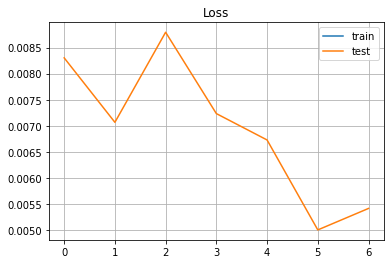

In [17]:
plt.plot(save_loss['train'])
plt.plot(save_loss['test'])
plt.legend(["train", "test"])
plt.title("Loss")
plt.grid(True)

Text(0.5, 1.0, 'Accuracy')

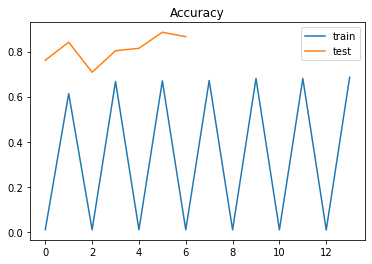

In [18]:
plt.plot(save_acc['train'])
plt.plot(save_acc['test'])
plt.legend(["train", "test"])
plt.title("Accuracy")

In [21]:
y_test = []
y_pred = []
model.eval()
with torch.no_grad():
    for (image, labels) in val_loader:
        image = image.cuda()
        labels = labels.cuda()
        outputs = model(image)
        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        val_loss += loss.data.item()
        y_test+= [labels.data]
        y_pred+=[preds]

In [22]:
print(len(y_test))

67


In [23]:
print(len(y_pred))

67


In [ ]:
from sklearn import svm, datasets
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer